# SQS elastic constants

This notebook demonstrates the functionality of job classes designed to calculate chemistry-dependent elastic data by averaging over one or more special-quasirandom structures.

The whole workflow for the notebook can be summarized as below:
<img src="Whole_workflow.png" />

The LAMMPS workflow can be described further as:
<img src="Lammps_workflow.png" />

In [1]:
from pyiron import Project
import pyiron_contrib
from elastic import ElasticMatrixJob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [2]:
pr = Project('scratch2')
#pr.remove_jobs(recursive=True)

# Setup reference jobs

The input to these SQS elastic job classes is quite minimal, rather run parameters are passed in in the form of reference jobs.

Of special importance are the `SQSJob` type reference, which handles the generation of special quasirandom structures, and `ElasticMatrixJob`, which computes the elastic constants. Thankfully, these jobs already existed, so the development of the new SQS elastic jobs was just a matter of stringing them together. 

An advantage of this setup is that any new improvements to the functionality of these underlying jobs is included in the SQS elastic jobs without having to modify SQS elastic code specifically, since they appear simply as references. However, the flip side of the coin is that the functionality of these jobs was not exhaustively tested. Results are very reasonable for the FCC Al system tested, but keep your physicist hat on when running the code and ensure that your results are coming out sensibly.

The final and most basic reference is the model which will interpret atomic positions to produce forces and energies. Here we'll use Lammps, but, if you have a lot of processor power lying around, there should be no barrier to using a quantum mechanical code like Vasp instead.

Here, we'll scale a lot of the input parameters way back so the calculations run faster.

In [3]:
lammps = pr.create_job(pr.job_type.Lammps, 'hr')
lammps.structure = pr.create_ase_bulk('Cu', cubic=True).repeat(5)
lammps.structure[:3] = 'Ni'

In [4]:
lammps.list_potentials()

['FeCuNi_eam_alloy',
 '1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1',
 '2009--Bonny-G--Fe-Cu-Ni--LAMMPS--ipr1',
 '1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1',
 '2009--Bonny-G--Fe-Cu-Ni--LAMMPS--ipr1',
 '2013--Onat-B--Cu-Ni--LAMMPS--ipr2',
 '2018--Farkas-D--Fe-Ni-Cr-Co-Cu--LAMMPS--ipr1',
 '2013--Onat-B--Cu-Ni--LAMMPS--ipr1',
 '2018--Farkas-D--Fe-Ni-Cr-Co-Cu--LAMMPS--ipr2',
 '1989--Adams-J-B--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1',
 '1986--Foiles-S-M--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1',
 'EAM_Dynamo_BonnyPasianotCastin_2009_FeCuNi__MO_469343973171_005',
 'EAM_Dynamo_OnatDurukanoglu_2014_CuNi__MO_592013496703_005',
 'EMT_Asap_Standard_JacobsenStoltzeNorskov_1996_AlAgAuCuNiPdPt__MO_115316750986_001']

In [5]:
lammps.potential = lammps.list_potentials()[1]
lammps.potential

,Config,Filename,Model,Name,Species
170,"[pair_style eam\n, pair_coeff 1 1 Cu_smf7.eam\...",[NISTiprpy/1985--Foiles-S-M--Ni-Cu--LAMMPS--ip...,NISTiprpy,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,"[Cu, Ni]"
385,"[pair_style eam\n, pair_coeff 1 1 Cu_smf7.eam\...",[NISTiprpy/1985--Foiles-S-M--Ni-Cu--LAMMPS--ip...,NISTiprpy,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,"[Cu, Ni]"


In [6]:
sqs = pr.create_job(pr.job_type.SQSJob, 'sr')
sqs.input.iterations = 100
sqs.input.weights = None
sqs.input.n_output_structures = 2 

In [7]:
elastic = pr.create_job(ElasticMatrixJob, 'er')
elastic.input['num_of_points'] = 3
elastic.input['fit_order'] = 2
elastic.input['eps_range'] = 0.005
elastic.input['relax_atoms'] = False
elastic.input['sqrt_eta'] = False

# Option 2: Scan various compositions

Alternatively, we might want to look for chemical trends across multiple different compositions. This is also possible. 

In [8]:
sqs_elastic_ref = pr.create_job(pr.job_type.SQSElasticConstants, 'se')
sqs_elastic_ref.ref_ham = lammps
sqs_elastic_ref.ref_sqs = sqs
sqs_elastic_ref.ref_elastic = elastic

job = sqs_elastic_ref.create_job(pr.job_type.SQSElasticConstantsList, 'scan')
job.input.compositions = [
    {'Cu': 1., 'Ni': 0.},
    {'Cu': 0.95, 'Ni': 0.05},
    {'Cu': 0.90, 'Ni': 0.10},
    {'Cu': 0.85, 'Ni': 0.15},
    {'Cu': 0.80, 'Ni': 0.20},
    {'Cu': 0.70, 'Ni': 0.30},
    {'Cu': 0.60, 'Ni': 0.40},
    {'Cu': 0.50, 'Ni': 0.50},
    {'Cu': 0.40, 'Ni': 0.60},
    {'Cu': 0.30, 'Ni': 0.70},
    {'Cu': 0.20, 'Ni': 0.80},
    {'Cu': 0.10, 'Ni': 0.90},
    {'Cu': 0., 'Ni': 1.}
]
job.run()

/opt/conda/lib/python3.8/site-packages/pyiron_base/generic/inputlist.py:323: UserWarning: The input in InputList changed, while the state of the job was already finished.
  warnings.warn(
2020-11-20 09:50:02,539 - pyiron_log - WARNING - The job scan is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


In [9]:
loaded = pr.load(job.job_name)

<AxesSubplot:xlabel='Ni Atomic fraction', ylabel='Elastic constants (GPa)'>

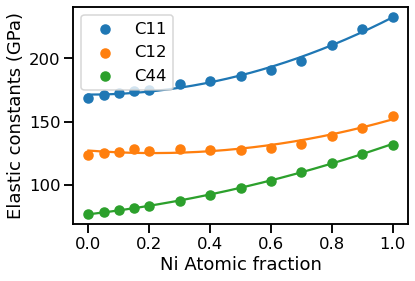

In [10]:
loaded.plot('Ni')

## DAMASK simulations
Here, we use the above fits to the data from lammps MD simulation to find the elastic constansts for a selected set of Ni concentrations. Then these values are given to DAMASK simulations to obtain the macroscopic elasto-plastic response.    

DAMASK workflow can be summarized in this form:
<img src="DAMASK_workflow.png" />

In [11]:
import os
cwd = os.getcwd()
print(cwd)
os.chdir(cwd)

/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow


In [12]:
concentrations=[0.0001,0.2,0.6,0.9999]

In [13]:
from damask import Geom
from damask import seeds
#import numpy as np
import subprocess,shlex
import os
import damask
from simulation_runner import simulation
simulation_folder =[]
job_file = []

#-------------------------------------
#GEOMETRY PARAMETERS
grid = np.array([16,16,16])
size = np.array([1.0,1.0,1.0])
grains = 20
seeds = seeds.from_random(size,grains)
#-------------------------------------

for i,c in enumerate(concentrations):
    # create folders, copy data etc.
    os.chdir(cwd)
    simulation_folder.append('Ni-{}'.format(int(c*100)))
    os.system('mkdir {}'.format(simulation_folder[i]))
    os.system('cp Examples/material.yaml {}'.format(simulation_folder[i]))
    os.system('cp Examples/tensionX.load {}/tension_Ni{}.load'.format(simulation_folder[i],int(c*100)))
    path = cwd+'/'+simulation_folder[i];
    print(path)
    
    #------------------------------------------------
    # LAMMPS TO DAMASK Coupling
    C11 = float(loaded.get_C11_poly('Ni')(c))
    C12 = float(loaded.get_C12_poly('Ni')(c))
    C44 = float(loaded.get_C44_poly('Ni')(c))
    print("moduli: {}, {}, {}".format(C11,C12,C44))
    #------------------------------------------------
    print(simulation_folder[i])
    #os.chdir(simulation_folder[i])
    os.chdir(path)
    load = 'tension_Ni{}.load'.format(int(c*100))
    geom_name = 'test.geom'
    material_config = 'material.yaml'
    job_file.append('{}_{}.hdf5'.format(geom_name.split('.')[0],load.split('.')[0]))
    
    #---------------------------------------------------------
    # Create geometry from scratch
    new_geom = Geom.from_Voronoi_tessellation(grid,size,seeds)
    new_geom.save_ASCII(geom_name)            # text based file
    new_geom.save(geom_name.split('.')[0])    # vtk file for visualization
    #---------------------------------------------------------
    
    C_matrix = [C11*1e9,C12*1e9,C44*1e9]
    elasticity={}
    elasticity.update({'type': 'hooke'})
    elastic_constants = {'C_11': C_matrix[0], 'C_12': C_matrix[1], 'C_44': C_matrix[2]}
    elasticity.update(elastic_constants)
    mat = damask.Config.load(material_config)
    mat['phase']['Aluminum']['elasticity'] = elasticity
    mat.save(material_config)
    simulation.run(simulation_folder[i],geom_name,load)
    print('simulation {} done'.format(str(i)))

/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/Ni-0
moduli: 171.39168441183762, 127.11482525692875, 76.6857446179937
Ni-0
simulation 0 done
/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/Ni-20
moduli: 173.77210230769833, 125.13439910987282, 83.43609635853247
Ni-20
simulation 1 done
/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/Ni-60
moduli: 193.31169204399694, 131.55594337503655, 103.53386597830276
Ni-60
simulation 2 done
/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/Ni-99
moduli: 232.5441220477391, 151.81883495812048, 132.41186369626678
Ni-99
simulation 3 done


## post processing of DAMASK simulations
Here, the data from damask simulations are post-process to obtain the list of strain, stress, and Von-Mises stress.

In [14]:
os.chdir(cwd)
import damask
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as PyPlot
import numpy as np
import h5py
#from Plot_stress_strain import plot
from damask_eval import eval_stress , eval_strain
%matplotlib inline
d = []
stresses = []
strains = []
#os.chdir(cwd)
for i,c in enumerate(concentrations):
    path = cwd+'/'+simulation_folder[i];
    os.chdir(path)
    #os.chdir(simulation_folder[i])
    d.append(damask.Result(job_file[i]))                  
    d[i].add_Cauchy()
    d[i].add_strain_tensor()
    d[i].add_Mises('sigma')
    d[i].add_Mises('epsilon_V^0.0(F)')
    d[i].add_calculation('avg_sigma',"np.average(#sigma_vM#)")
    d[i].add_calculation('avg_epsilon',"np.average(#epsilon_V^0.0(F)_vM#)")
    d[i].save_vtk(['sigma','epsilon_V^0.0(F)','sigma_vM','epsilon_V^0.0(F)_vM'])
    stresses.append(eval_stress(job_file[i]))
    strains.append(eval_strain(job_file[i]))

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/damask_eval.py:19: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hdf = h5py.File(d.fname)
/home/pyiron_user/pyiron/projects/pyir

## Visualization
Here, you can find the stress-strain relation for different concentrations of Ni in a Cu-Ni alloy. The main difference lies in the elastic part. Therefore, the stain range is modified to visualize elastic deformation better.

Text(0.5, 1.0, 'Stress-Strain')

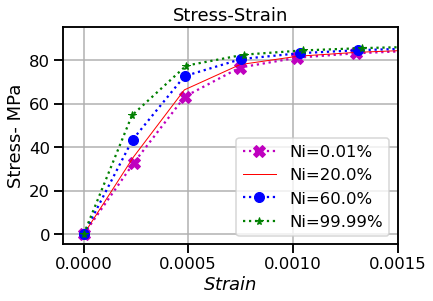

In [15]:
import matplotlib.pyplot as plt
i = 0;
#stresses[0]= eval_stress(job_file[0])
#stresses[1]= eval_stress(job_file[1])
#stresses[2]= eval_stress(job_file[2])
colors = ['r','g','b']
#for color, strain, stress, c in zip(colors, strains, stresses, concentrations):
plt.plot(strains[0], stresses[0], 'm', linestyle="dotted",marker = 'X' ,markersize = 12,label = 'Ni={}%'.format(0.0001*100))
plt.plot(strains[1], stresses[1], 'r', linewidth=1, label = 'Ni={}%'.format(0.2*100))
plt.plot(strains[2], stresses[2], 'b', linestyle="dotted",marker = 'o' ,markersize = 10,label = 'Ni={}%'.format(0.6*100))
plt.plot(strains[3], stresses[3], 'g', linestyle="dotted",marker = '*', markersize = 8 ,label = 'Ni={}%'.format(0.9999*100))
plt.xlim(-0.0001,0.0015)
plt.grid(True)
plt.xlabel('$Strain$')
plt.ylabel('Stress- MPa')
plt.legend( loc='lower right')
plt.title("Stress-Strain")

## VTK visualization

Import visualization modules

In [16]:
import pyvista as pv
from itkwidgets import view

Visualizing initial geometry

In [17]:
#path = cwd+'/'+simulation_folder[0]   # put the simulation number here
#filepath = path + '/' + 'test.vtr' # put correct name for the geometry file
filepath = '/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/Ni-20/test.vtr'

In [18]:
mesh = pv.read(filepath)
mesh

RectilinearGrid (0x7feee8f80520)
  N Cells:	4096
  N Points:	4913
  X Bounds:	0.000e+00, 1.000e+00
  Y Bounds:	0.000e+00, 1.000e+00
  Z Bounds:	0.000e+00, 1.000e+00
  Dimensions:	17, 17, 17
  N Arrays:	2

## Input microstructure/geometry

In [19]:
pl = pv.PlotterITK()
pl.add_mesh(mesh)
pl.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

## Visualize stress strain distributions

In [23]:
#path = cwd+'/'+simulation_folder[0]
#filepath = path + '/' + 'test_tension_Ni20_inc20.vtr'   #put the correct name for the vtr file
filepath = '/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/Ni-20/test_tension_Ni20_inc10.vtr'


In [24]:
mesh = pv.read(filepath)
mesh

RectilinearGrid (0x7feea4ce0160)
  N Cells:	4096
  N Points:	4913
  X Bounds:	0.000e+00, 1.000e+00
  Y Bounds:	0.000e+00, 1.000e+00
  Z Bounds:	0.000e+00, 1.000e+00
  Dimensions:	17, 17, 17
  N Arrays:	5

In [25]:
pl = pv.PlotterITK()
pl.add_mesh(mesh)
pl.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…